In [1]:
!pwd

/reg/data/ana03/scratch/cwang31/spi


In [2]:
# Load paths for using psana
%env SIT_ROOT=/reg/g/psdm/
%env SIT_DATA=/cds/group/psdm/data/
%env SIT_PSDM_DATA=/cds/data/psdm/

env: SIT_ROOT=/reg/g/psdm/
env: SIT_DATA=/cds/group/psdm/data/
env: SIT_PSDM_DATA=/cds/data/psdm/


In [3]:
import os
import logging
import torch
import socket
import pickle
import tqdm

from deepprojection.datasets.lite    import SPIDataset         , SPIOnlineDataset
from deepprojection.model            import OnlineSiameseModel , ConfigSiameseModel
from deepprojection.trainer          import OnlineTrainer      , ConfigTrainer
from deepprojection.validator        import OnlineLossValidator, ConfigValidator
from deepprojection.encoders.convnet import Hirotaka0122       , ConfigEncoder
from deepprojection.utils            import EpochManager       , MetaLog, init_logger, split_dataset
from datetime import datetime
from image_preprocess import DatasetPreprocess

# [[[ CONFIG ]]]
timestamp_prev = None
frac_train = 0.25
frac_validate = 0.5

lr = 1e-3
alpha = 2.0
seed = 0

size_sample_train = 500
size_sample_validate = 500
size_sample_per_class = None
size_batch = 200
online_shuffle = True
trans = None

# [[[ LOGGING ]]]
timestamp = init_logger(returns_timestamp = True)

# Clarify the purpose of this experiment...
hostname = socket.gethostname()
comments = f"""
            Hostname: {hostname}.

            Online training.

            Sample size (train)     : {size_sample_train}
            Sample size (validate)  : {size_sample_validate}
            Sample size (per class) : {size_sample_per_class}
            Batch  size             : {size_batch}
            Alpha                   : {alpha}
            Online shuffle          : {online_shuffle}
            lr                      : {lr}

            """


# [[[ DATASET ]]]
# Set up parameters for an experiment...
drc_dataset   = 'fastdata'
fl_dataset    = '0000.fastdata'    # Raw, just give it a try
path_dataset  = os.path.join(drc_dataset, fl_dataset)

# Load raw data...
with open(path_dataset, 'rb') as fh:
    dataset_list = pickle.load(fh)

# Split data...
data_train   , data_val_and_test = split_dataset(dataset_list     , frac_train   , seed = seed)
data_validate, data_test         = split_dataset(data_val_and_test, frac_validate, seed = seed)

# Define the training set
dataset_train = SPIOnlineDataset( dataset_list = data_train, 
                                  size_sample  = size_sample_train,
                                  size_sample_per_class = size_sample_per_class, 
                                  trans = trans, 
                                  seed  = seed, )

# Define the training set
dataset_validate = SPIOnlineDataset( dataset_list = data_validate, 
                                     size_sample  = size_sample_train,
                                     size_sample_per_class = size_sample_per_class, 
                                     trans = trans, 
                                     seed  = seed, )

In [4]:
for i, item in enumerate(dataset_validate):
    if i > 10: break
    print(item[2])

('amo06516', '91', ' 51978', '2')
('amo06516', '96', '143240', '2')
('amo06516', '96', '116909', '1')
('amo06516', '91', ' 10534', '0')
('amo06516', '94', ' 23088', '1')
('amo06516', '90', ' 56157', '1')
('amo06516', '90', ' 15919', '2')
('amo06516', '96', ' 43875', '0')
('amo06516', '91', ' 54475', '1')
('amo06516', '91', ' 23906', '1')
('amo06516', '90', '   591', '2')


In [5]:
for i, item in enumerate(dataset_validate):
    if i > 10: break
    print(item[2])

('amo06516', '91', ' 51978', '2')
('amo06516', '96', '143240', '2')
('amo06516', '96', '116909', '1')
('amo06516', '91', ' 10534', '0')
('amo06516', '94', ' 23088', '1')
('amo06516', '90', ' 56157', '1')
('amo06516', '90', ' 15919', '2')
('amo06516', '96', ' 43875', '0')
('amo06516', '91', ' 54475', '1')
('amo06516', '91', ' 23906', '1')
('amo06516', '90', '   591', '2')


In [6]:
dataset_train[0]

(array([[[-0.10398383,  0.03491898, -0.09542035, ..., -0.00073364,
          -0.07698455,  0.0912585 ],
         [-0.14891362,  0.01378856, -0.10509702, ...,  0.10408345,
          -0.0161233 ,  0.10839733],
         [-0.09408585, -0.05527322, -0.04292893, ...,  0.00649507,
          -0.08572904,  0.15818281],
         ...,
         [ 0.10999746, -0.06048281, -0.00281666, ..., -0.0639746 ,
          -0.00759374, -0.05091143],
         [ 0.07487232, -0.03977283, -0.07455577, ..., -0.11376868,
           0.03963405, -0.03528195],
         [ 0.05793897, -0.05693524, -0.07272473, ..., -0.09021135,
          -0.04231576,  0.01261501]]], dtype=float32),
 2,
 ('amo06516', '94', ' 24848', '2'))

### Preprocess

In [7]:
# Preprocess dataset...
# Data preprocessing can be lengthy and defined in dataset_preprocess.py
img_orig            = dataset_train[0][0][0]   # idx, fetch img
dataset_preproc     = DatasetPreprocess(img_orig)
trans               = dataset_preproc.config_trans()
dataset_train.trans = trans
dataset_validate.trans = trans
img_trans           = dataset_train[0][0][0]

#### Just checking

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

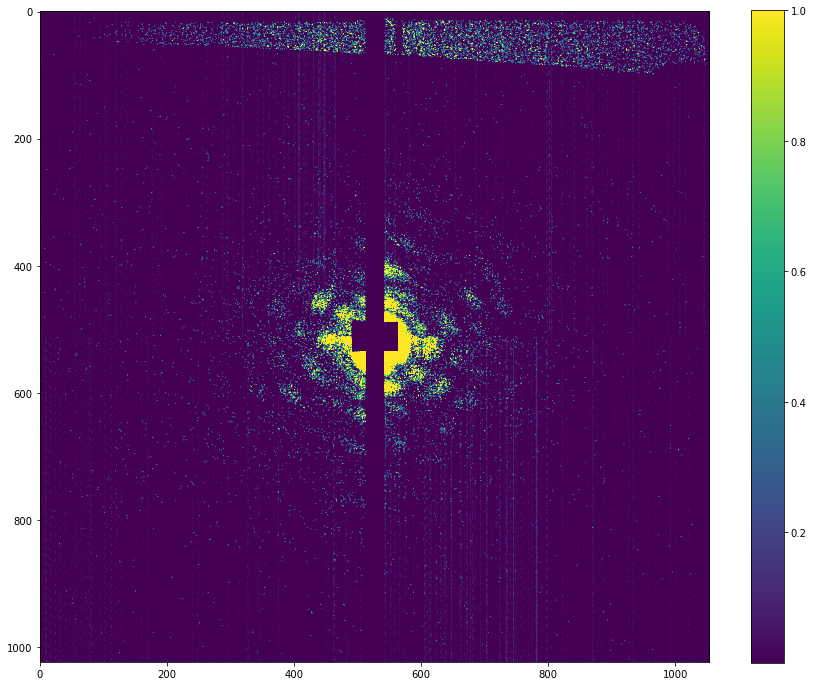

In [7]:
plt.figure(figsize = (15, 12))
data = img_orig
vmin = data.mean()
vmax = vmin + 1 * data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)
plt.colorbar()

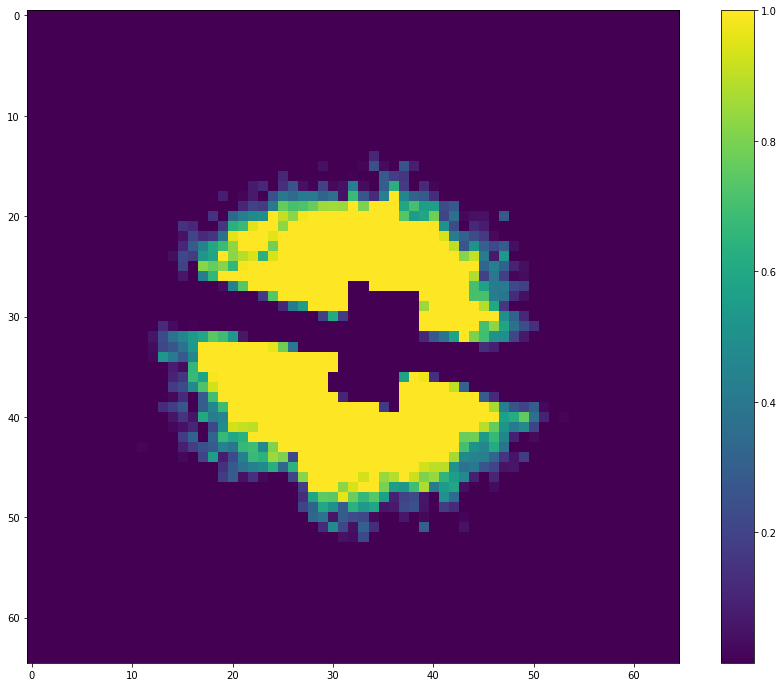

In [8]:
plt.figure(figsize = (15, 12))
data = dataset_train[134][0][0]
vmin = data.mean()
vmax = vmin + 1 * data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)
plt.colorbar()

### Load model

In [9]:
# [[[ IMAGE ENCODER ]]]
# Config the encoder...
dim_emb        = 128
size_y, size_x = img_trans.shape[-2:]
config_encoder = ConfigEncoder( dim_emb = dim_emb,
                                size_y  = size_y,
                                size_x  = size_x,
                                isbias  = True )
encoder = Hirotaka0122(config_encoder)


# [[[ MODEL ]]]
# Config the model...
config_siamese = ConfigSiameseModel( alpha = alpha, encoder = encoder, )
model = OnlineSiameseModel(config_siamese)
model.init_params(from_timestamp = timestamp_prev)

### Config trainer and validator

In [10]:
# [[[ CHECKPOINT ]]]
drc_cwd          = os.getcwd()
DRCCHKPT         = "chkpts"
prefixpath_chkpt = os.path.join(drc_cwd, DRCCHKPT)
fl_chkpt         = f"{timestamp}.train.chkpt"
path_chkpt       = os.path.join(prefixpath_chkpt, fl_chkpt)


# [[[ TRAINER ]]]
# Config the trainer...
config_train = ConfigTrainer( path_chkpt     = path_chkpt,
                              num_workers    = 1,
                              batch_size     = size_batch,
                              pin_memory     = True,
                              shuffle        = False,
                              is_logging     = False,
                              online_shuffle = online_shuffle,
                              method         = 'random-semi-hard', 
                              lr             = lr, 
                              tqdm_disable   = True)

# Training...
trainer = OnlineTrainer(model, dataset_train, config_train)


# [[[ VALIDATOR ]]]
config_validator = ConfigValidator( path_chkpt     = None,
                                    num_workers    = 1,
                                    batch_size     = size_batch,
                                    pin_memory     = True,
                                    shuffle        = False,
                                    is_logging     = False,
                                    online_shuffle = online_shuffle,
                                    method         = 'random-semi-hard', 
                                    lr             = lr,
                                    tqdm_disable   = True)  # Conv2d input needs one more dim for batch
validator = OnlineLossValidator(model, dataset_validate, config_validator)

### Training epochs

In [11]:
loss_train_hist = []
loss_validate_hist = []
loss_min_hist = []

# [[[ EPOCH MANAGER ]]]
epoch_manager = EpochManager( trainer   = trainer,
                              validator = validator,
                              timestamp = timestamp, )

# epoch_manager.set_layer_to_capture(
#     module_name_capture_list  = ["final_conv"],
#     module_layer_capture_list = [torch.nn.ReLU],
# )

In [ ]:
max_epochs = 100
freq_save = 5
for epoch in tqdm.tqdm(range(max_epochs), disable=False):
    loss_train, loss_validate, loss_min = epoch_manager.run_one_epoch(epoch = epoch, returns_loss = True)
    
    loss_train_hist.append(loss_train)
    loss_validate_hist.append(loss_validate)
    loss_min_hist.append(loss_min)

    # if epoch % freq_save == 0: 
    #     epoch_manager.save_model_parameters()
    #     epoch_manager.save_model_gradients()
    #     epoch_manager.save_state_dict()

  2%|▏         | 2/100 [00:05<04:40,  2.86s/it]

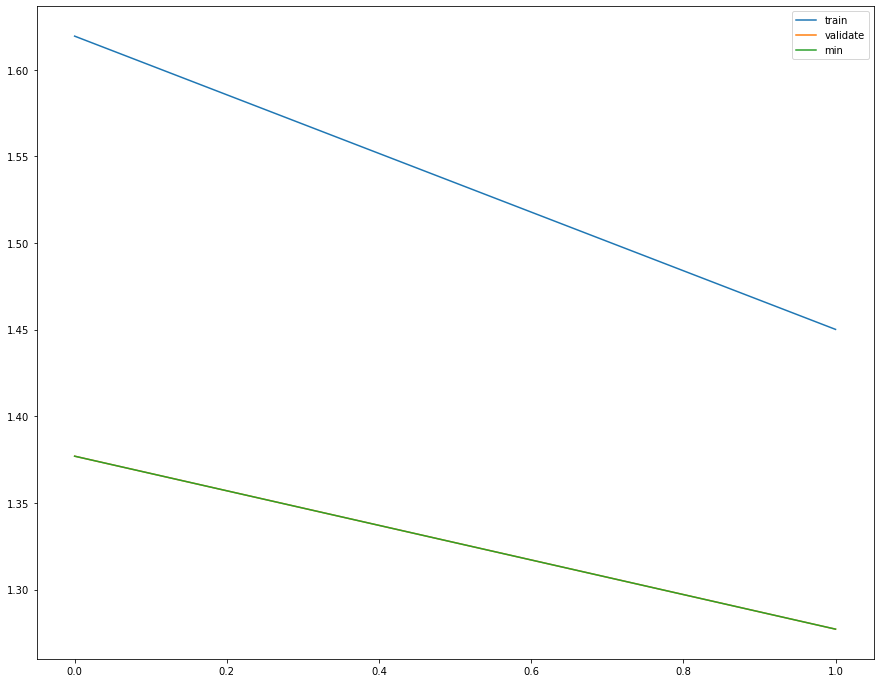

In [15]:
plt.figure(figsize = (15, 12))
x = range(len(loss_train_hist))
y = loss_train_hist
plt.plot(x, y, label = 'train')

x = range(len(loss_validate_hist))
y = loss_validate_hist
plt.plot(x, y, label = 'validate')

x = range(len(loss_min_hist))
y = loss_min_hist
plt.plot(x, y, label = 'min')

plt.legend()

### Test

In [16]:
from deepprojection.datasets.lite import MultiwayQueryset
from deepprojection.model import SiameseModelCompare
from deepprojection.validator import MultiwayQueryValidator

# Define the test set
size_sample_test = 1000
size_sample_per_class = None
size_batch = 100
online_shuffle = True
dataset_test = MultiwayQueryset( dataset_list = data_test, 
                                 size_sample  = size_sample_test,
                                 size_sample_per_class = size_sample_per_class, 
                                 trans = trans, 
                                 seed  = seed, )

# Set up the model
config_siamese_test = ConfigSiameseModel( encoder = encoder, )
model_test = SiameseModelCompare(config_siamese_test)
model_test.init_params(from_timestamp = timestamp_prev)

In [17]:
config_tester = ConfigValidator( num_workers = 1,
                                    batch_size  = size_batch,
                                    pin_memory  = True,
                                    shuffle     = False,
                                    isflat      = False,
                                    lr          = lr, )

tester = MultiwayQueryValidator(model_test, dataset_test, config_tester)
batch_metadata_query_list, batch_metadata_support_list, batch_dist_support_list = tester.validate(returns_details = True)

100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


In [20]:
len(batch_dist_support_list), len(batch_dist_support_list[0]), len(batch_dist_support_list[0][0])

(10, 3, 100)

In [28]:
len(batch_metadata_support_list), len(batch_metadata_support_list[0]), len(batch_metadata_support_list[0][0])

(10, 3, 100)

In [35]:
import numpy as np
idx_min_value_list = np.argmin(batch_dist_support_list, axis = 1)
idx_min_value_list.shape

(10, 100)

In [55]:
batch_metadata_support_selected_list = []
for idx_batch in range(len(batch_metadata_support_list)):
    metadata_support_selected_list = []
    for idx_example in range(len(batch_metadata_support_list[0][0])):
        idx_min_value = idx_min_value_list[idx_batch][idx_example]
        metadata_support_selected = batch_metadata_support_list[idx_batch][idx_min_value][idx_example]
        metadata_support_selected_list.append(metadata_support_selected)
    batch_metadata_support_selected_list.append(metadata_support_selected_list)

In [61]:
len(batch_metadata_support_selected_list), batch_metadata_support_selected_list[0][:10]

(10,
 ['amo06516 94  22318 2',
  'amo06516 96  10529 0',
  'amo06516 94  14894 2',
  'amo06516 102   2796 0',
  'amo06516 94  49870 1',
  'amo06516 91  33570 1',
  'amo06516 96  17317 2',
  'amo06516 96  54666 2',
  'amo06516 96 173832 2',
  'amo06516 96 190441 1'])

In [41]:
class MacroMetric:
    def __init__(self, res_dict):
        self.res_dict = res_dict


    def reduce_confusion(self, label):
        ''' Given a label, reduce multiclass confusion matrix to binary
            confusion matrix.
        '''
        res_dict    = self.res_dict
        labels      = res_dict.keys()
        labels_rest = [ i for i in labels if not i == label ]

        # Early return if non-exist label is passed in...
        if not label in labels: 
            print(f"label {label} doesn't exist!!!")
            return None

        # Obtain true positive...
        tp = len(res_dict[label][label])
        fp = sum( [ len(res_dict[label][i]) for i in labels_rest ] )
        tn = sum( sum( len(res_dict[i][j]) for j in labels_rest ) for i in labels_rest )
        fn = sum( [ len(res_dict[i][label]) for i in labels_rest ] )

        return tp, fp, tn, fn


    def get_metrics(self, label):
        # Early return if non-exist label is passed in...
        confusion = self.reduce_confusion(label)
        if confusion is None: return None

        # Calculate metrics...
        tp, fp, tn, fn = confusion
        accuracy    = (tp + tn) / (tp + tn + fp + fn)
        precision   = tp / (tp + fp)
        recall      = tp / (tp + fn)
        specificity = tn / (tn + fp) if tn + fp > 0 else None
        f1_inv      = (1 / precision + 1 / recall)
        f1          = 2 / f1_inv

        return accuracy, precision, recall, specificity, f1


In [62]:
labels = set([ metadata.split()[-1] for batch_metadata in batch_metadata_query_list for metadata in batch_metadata[0] ])
labels

{'0', '1', '2'}

In [63]:
# New container to store validation result (thus res_dict) for each label...
res_dict = {}
for label in labels: res_dict[label] = { i : [] for i in labels }

In [64]:
len(batch_metadata_support_selected_list)

100

In [66]:
for idx_batch in range(len(batch_metadata_support_list)):
    for idx_example in range(len(batch_metadata_query_list[idx_batch][0])):
        metadata_true = batch_metadata_query_list[idx_batch][0][idx_example]
        metadata_pred = batch_metadata_support_selected_list[idx_batch][idx_example]
        label_true = metadata_true.split()[-1]
        label_pred = metadata_pred.split()[-1]
        res_dict[label_pred][label_true].append( (metadata_true, metadata_pred) )

In [67]:
# Get macro metrics...
macro_metric = MacroMetric(res_dict)

# Formating purpose...
disp_dict = { "0" : "not-sample",
              "1" : "single-hit",
              "2" : " multi-hit",
              "9" : "background",
            }

# Report multiway classification...
msgs = []
for label_pred in labels:
    disp_text = disp_dict[label_pred]
    msg = f"{disp_text}  |"
    for label_real in labels:
        num = len(res_dict[label_pred][label_real])
        msg += f"{num:>12d}"

    metrics = macro_metric.get_metrics(label_pred)
    for metric in metrics:
        msg += f"{metric:>12.2f}"
    msgs.append(msg)

msg_header = " " * (msgs[0].find("|") + 1)
for label in labels: 
    disp_text = disp_dict[label]
    msg_header += f"{disp_text:>12s}"

for header in [ "accuracy", "precision", "recall", "specificity", "f1" ]:
    msg_header += f"{header:>12s}"
print(msg_header)

msg_headerbar = "-" * len(msgs[0])
print(msg_headerbar)
for msg in msgs:
    print(msg)

               single-hit   multi-hit  not-sample    accuracy   precision      recall specificity          f1
-------------------------------------------------------------------------------------------------------------
single-hit  |         126          97          76        0.62        0.42        0.38        0.74        0.40
 multi-hit  |         115         111         119        0.54        0.32        0.33        0.65        0.33
not-sample  |          95         127         134        0.58        0.38        0.41        0.67        0.39
